In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Mall_Customers.csv to Mall_Customers.csv


In [ ]:
#@title imports

import numpy as np
import pandas as pd
from pandas import plotting
import matplotlib.pyplot as plt
import seaborn as sns

import plotly as py

from sklearn.preprocessing import StandardScaler

import seaborn as sns
from plotly import tools
from plotly.subplots import make_subplots
import plotly.offline as py
from sklearn.preprocessing import LabelEncoder
%matplotlib inline


In [ ]:
dataset = pd.read_csv('Mall_Customers.csv')

Exploring the Annual Income Column for Further Analysis

In [ ]:

dataset.rename(index=str, columns={'Annual Income (k$)': 'Income',
                              'Spending Score (1-100)': 'Score'}, inplace=True)
dataset.drop('CustomerID',axis=1,inplace=True)
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(dataset['Gender'].values)
dataset['Gender'] = integer_encoded
dataset.head(3)

,Gender,Age,Income,Score
0,1,19,15,39
1,1,21,15,81
2,0,20,16,6


Segmentation using all the Features

In [ ]:
#@title FCM
class FCM:
    def __init__(self,
                 min_improvement,
                 n_clusters,
                 max_iterations,
                 fuzzification_degree,
                 dirichlet_concentration_params=None,
                 metric='euclidean',
                 verbose=False):
        self.objective = np.inf
        self.objective_history = []
        self.max_iterations = max_iterations
        self.min_improvement = min_improvement
        self.n_clusters = n_clusters
        self.fuzzification_degree = fuzzification_degree
        self.dirichlet_concentration_params = dirichlet_concentration_params
        self.metric = self.__get_metric(metric)
        self.verbose = verbose
        self._vpc = np.nan


    def get_random_dirichlet_membership(self,dirichlet_concentration_params):

        if dirichlet_concentration_params is None:
            dirichlet_concentration_params = np.array([2.0]*self.n_clusters)

        assert dirichlet_concentration_params.shape[0] == self.n_clusters, \
            f"dirichlet_concentration_params {dirichlet_concentration_params} does not match the number of clusters {n_clusters}"

        return np.random.dirichlet(dirichlet_concentration_params,size=self.n_samples)

    def set_membership_degree(self,membership_degree):
        self.membership_degree = membership_degree

    def fit(self,X,init_membership_degree=None):
        assert isinstance(X,np.ndarray),"input of fit method should be a numpy array"
        self.X = X
        self.n_samples, self.n_features = self.X.shape
        self.distance_matrix = np.zeros(shape=(self.n_samples,self.n_clusters))
        if init_membership_degree is None:
            init_membership_degree = self.get_random_dirichlet_membership(self.dirichlet_concentration_params)
        self.set_membership_degree(init_membership_degree)
        self.normalize_membership_degree()

        iteration = 0
        while True:
            self.update_centers()
            self.update_distances()
            self.update_membership_degree()
            self.update_objective()
            if self.stopping_criterion(iteration):
                print(self.MCD(),self.xi_beni(),self.lables())
                break
            iteration += 1
            if self.verbose:
                print(self.vpc())

    def update_centers(self):
        self.fuzzy_membership_degree = self.membership_degree ** self.fuzzification_degree
        self.centers = (self.fuzzy_membership_degree.T @ self.X)/np.expand_dims(self.fuzzy_membership_degree.sum(axis=0),1)

    def update_objective(self):
        self.objective = (self.fuzzy_membership_degree * self.distance_matrix_squared).sum()
        self.objective_history.append(self.objective)

    def stopping_criterion(self,iteration):
        if iteration > self.max_iterations:
            return True

        if iteration > 2:
            self.improvement = np.abs(self.objective_history[-2] - self.objective_history[-1])
            return self.improvement < self.min_improvement

        return False

    def update_distances(self):
        for center_idx in range(self.n_clusters):
            self.distance_matrix[:,center_idx] = self.metric(np.expand_dims(self.centers[center_idx],0),self.X)

    def update_membership_degree(self):
        self.distance_matrix_squared = self.distance_matrix ** 2
        for center_idx in range(self.n_clusters):
            for sample_idx in range(self.n_samples):
                temp = self.distance_matrix_squared[sample_idx,center_idx]/self.distance_matrix_squared[sample_idx,:]
                self.membership_degree[sample_idx,center_idx] = 1/((temp.sum())**(2/(self.fuzzification_degree-1)))
        self.normalize_membership_degree()

    def normalize_membership_degree(self):
        self.membership_degree = self.membership_degree/self.membership_degree.sum(axis=1,keepdims=True)

    def __get_metric(self,name):
        metrics = {'euclidean' : self.__euclid_metric,
                   'cosine': self.__cosine_metric}
        return metrics[name]

    def __euclid_metric(self,x,y):
        return np.linalg.norm(x-y,axis=1)

    def __cosine_metric(self,x,y):
        return 1 - np.dot(x,y.T)/(np.linalg.norm(x)*np.linalg.norm(y))
    def xi_beni(self):
         b=[]
         for i in (self.centers):
            for j in (self.centers):
                  b.append((np.linalg.norm(i-j))**2)
            if 0 in b:
                b.remove(0)
         b.sort()
         c=b[0]
         self.a=(self.n_samples)*c
         return self.a
    def MCD(self):
        M=[]
        for i in (self.centers):
          for j in (self.centers):
            M.append((np.linalg.norm(i-j))**2)
            if 0 in M:
                M.remove(0)
        M.sort()
        self.F=M[0]
        return self.F
    def update_centers2(self):
        self.fuzzy_membership_degree = self.membership_degree ** self.fuzzification_degree
        self.centers = (self.fuzzy_membership_degree.T @ self.X)/np.expand_dims(self.fuzzy_membership_degree.sum(axis=0),1)
        return self.centers
    def lables(self):
        self.predict= np.argmax(self.membership_degree, axis=1)
        return self.predict

2343.0839229577364 468616.7845915473 [1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 0 1 0 1
 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1
 0 1 0 1 0 1 0 1 0 1 0 0 0 0 0]
2690.594049614453 538118.8099228906 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2
 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1
 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2]
1986.8244308738097 397364.8861747619 [1 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3
 

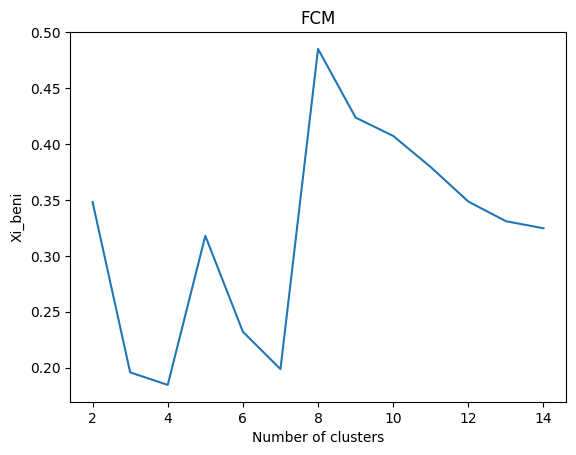

In [ ]:
#@title Determining optimal number of clusters using xi and beni index

cmin=2
n_samples=200
cmax=np.sqrt(n_samples)
cmax=int(cmax)
cmax+=1
hub=[]
clusters = range(cmin,cmax)
epsilon = 0.5
x=dataset
for i in clusters:
    n_centers=i
    clustering_instance = FCM(min_improvement=0.1,
                             n_clusters=n_centers,
                             max_iterations=100,
                             fuzzification_degree=2,
                             metric='euclidean')
    np_x = x.to_numpy()
    clustering_instance.fit(np_x)
    hub.append(clustering_instance.objective_history[-1]/(clustering_instance.a))
plt.title("FCM")
plt.xlabel('Number of clusters')
plt.ylabel('Xi_beni')
plt.plot(clusters,hub)

2347.886956748685 469577.391349737 [1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 0 1 0 1
 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1
 0 1 0 1 0 1 0 1 0 1 0 0 0 0 0]
2696.7619562023924 539352.3912404785 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1
 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]
1987.5127572887159 397502.55145774316 [2 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0
 

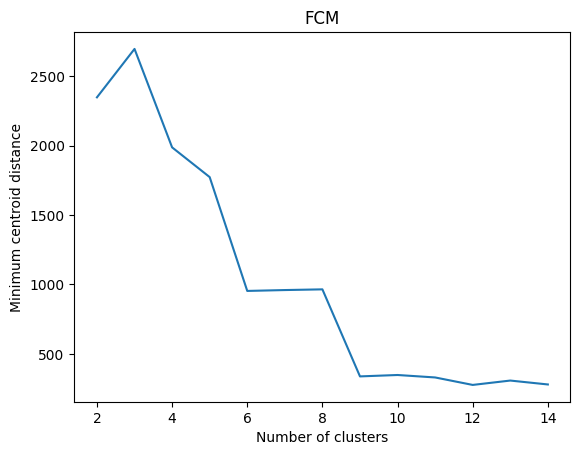

In [ ]:
#@ title Determining optimal number of clusters using Ⅿiniⅿuⅿ ⅽentroiⅾ ⅾistanⅽe index
cmin=2
n_samples=200
cmax=np.sqrt(n_samples)
cmax=int(cmax)
cmax+=1
hub=[]
clusters = range(cmin,cmax)
epsilon = 0.5
x=dataset
for i in clusters:
    n_centers=i
    clustering_instance = FCM(min_improvement=0.1,
                             n_clusters=n_centers,
                             max_iterations=100,
                             fuzzification_degree=2,
                             metric='euclidean')
    np_x = x.to_numpy()
    clustering_instance.fit(np_x)
    hub.append(clustering_instance.F)
plt.title("FCM")
plt.xlabel('Number of clusters')
plt.ylabel('Ⅿiniⅿuⅿ ⅽentroiⅾ ⅾistanⅽe')
plt.plot(clusters,hub)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



<Figure size 1200x800 with 0 Axes>

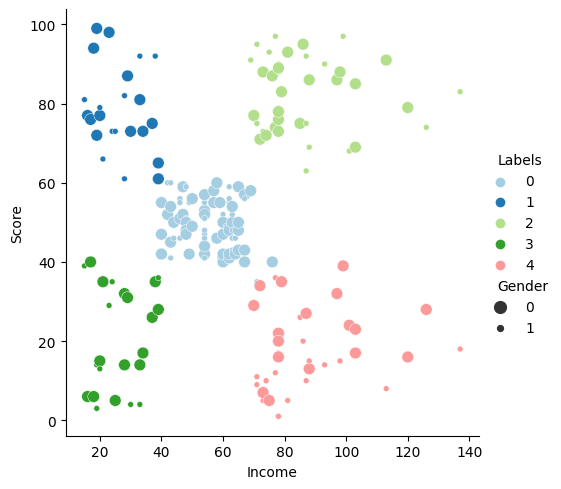

In [ ]:
#@title Grand trouth(K-means)
from sklearn.cluster import KMeans
km5 = KMeans(n_clusters=5).fit(dataset)

dataset['Labels'] = km5.labels_
plt.figure(figsize=(12, 8))
sns.relplot(x='Income', y='Score', hue='Labels', size='Gender',
                 data=dataset,palette = "Paired")

plt.show()

In [ ]:
#@title visualizations
n_centers = 5
epsilon = 0.5
x=dataset
clustering_instance = FCM(min_improvement=0.1,
                             n_clusters=n_centers,
                             max_iterations=100,
                             fuzzification_degree=2,
                             metric='euclidean')
np_x = x.to_numpy()
clustering_instance.fit(np_x)
x['Labels'] = clustering_instance.predict


1772.9966384731554 354599.32769463107 [4 0 4 0 4 0 4 0 4 0 4 0 4 0 4 0 4 0 4 0 4 0 4 0 4 0 4 0 4 0 4 0 4 0 4 0 4
 0 4 0 4 0 2 0 4 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 0 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 3 1 3 2 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3
 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1
 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3]


<Figure size 1200x800 with 0 Axes>

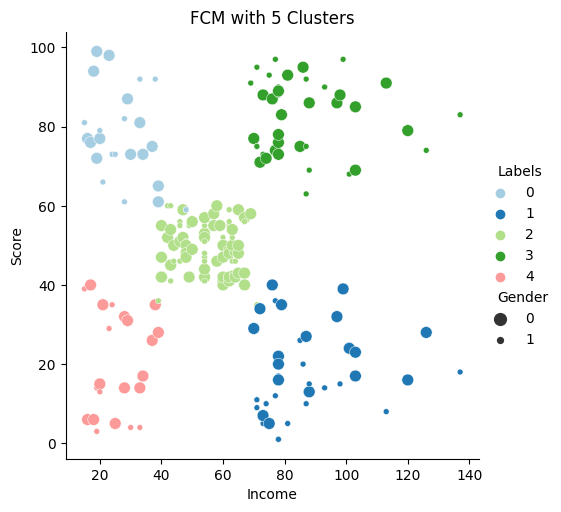

In [ ]:
x['Labels'] = clustering_instance.predict
clustering_centers = clustering_instance.centers
membership_degree = clustering_instance.membership_degree

plt.figure(figsize=(12, 8))
sns.relplot(x='Income', y='Score', hue='Labels', size='Gender',
                 data=dataset,palette = "Paired")
plt.title('FCM with 5 Clusters')
plt.show()

In [ ]:
n_centers = 6
epsilon = 0.5
x=dataset
clustering_instance = FCM(min_improvement=0.1,
                             n_clusters=n_centers,
                             max_iterations=100,
                             fuzzification_degree=2,
                             metric='euclidean')
np_x = x.to_numpy()
clustering_instance.fit(np_x)
x['Labels'] = clustering_instance.predict

953.2646882620535 190652.9376524107 [3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3
 1 3 1 4 1 4 2 3 1 4 2 2 2 4 2 2 4 4 4 4 4 2 4 4 2 4 4 4 2 4 4 2 2 4 4 4 4
 4 2 4 2 2 4 4 2 4 4 2 4 4 2 2 4 4 2 4 2 2 2 4 2 4 2 2 4 4 2 4 2 4 4 4 4 4
 2 2 2 2 2 4 4 4 4 2 2 2 5 2 5 0 5 0 5 0 5 2 5 0 5 0 5 0 5 0 5 2 5 0 5 0 5
 0 5 0 5 0 5 0 5 0 5 0 5 0 5 0 5 0 5 0 5 0 5 0 5 0 5 0 5 0 5 0 5 0 5 0 5 0
 5 0 5 0 5 0 5 0 5 0 5 0 5 0 5]


<Figure size 1200x800 with 0 Axes>

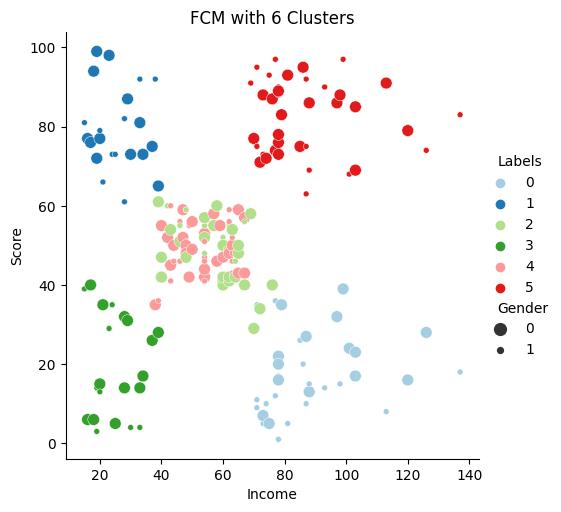

In [ ]:
x['Labels'] = clustering_instance.predict
clustering_centers = clustering_instance.centers
membership_degree = clustering_instance.membership_degree

plt.figure(figsize=(12, 8))
sns.relplot(x='Income', y='Score', hue='Labels', size='Gender',
                 data=dataset,palette = "Paired")
plt.title('FCM with 6 Clusters')
plt.show()

In [ ]:
#@title Internal evaluation
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score


print("Silhouette score: {}".format(silhouette_score(dataset.drop(['Labels'],axis=1), clustering_instance.predict)))
print("Davies Bouldin score: {}".format(davies_bouldin_score(dataset.drop(['Labels'], axis=1),  clustering_instance.predict)))
print("Calinski Harabasz score: {}".format(calinski_harabasz_score(dataset.drop(['Labels'], axis=1), clustering_instance.predict)))


Silhouette score: 0.4521697610505392
Davies Bouldin score: 0.7474363913372746
Calinski Harabasz score: 166.70431796937396


In [ ]:
#@title External evaluation
from sklearn.cluster import KMeans
km5 = KMeans(n_clusters=5).fit(x)
x['La'] = km5.labels_


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [ ]:
from sklearn.metrics import fowlkes_mallows_score
from sklearn.metrics import rand_score
from sklearn.metrics import v_measure_score
print("Rand score: {}".format(rand_score(km5.labels_, clustering_instance.predict)))
print("fowlkes mallows score: {}".format(fowlkes_mallows_score(km5.labels_, clustering_instance.predict)))
print("v measure score: {}".format(v_measure_score(km5.labels_, clustering_instance.predict)))

Rand score: 0.9024120603015076
fowlkes mallows score: 0.781859918793339
v measure score: 0.8416951126331395
